In [1]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
warnings.filterwarnings('ignore')

In [2]:
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

def plot_gs_results(gs_model, params, check_params, model_name = ''):
    plt.figure(figsize=(12,6))
    ## plt.title(model_name + " dependency from "+ str(check_params))
    plt.plot(params[check_params], gs_model.cv_results_["mean_train_score"],"o-",label="train")
    plt.plot(params[check_params], gs_model.cv_results_["mean_test_score"],"o-",label="test")
    plt.xlabel(check_params)
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def gs_regressor_params(parameters ={}, check_parameter={}, metric="accuracy", reg=None, n_splits=1, test_size=0.20):
    metric = make_scorer(my_accuracy)
    cv = TimeSeriesSplit(n_splits=n_splits)
    gs_reg = GridSearchCV(reg, parameters, cv=cv, scoring=metric, return_train_score=True, verbose=False)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

In [3]:
data = pd.read_pickle('final_data.pkl')
print(data.shape)
data.head(1)

(34588, 132)


,,,Surface,hour,round,p1_win,p1_age,p2_age,k1,k2,p1_height,p2_height,...,p2_filter_lag_1_receiver_points_won_match__mean_28,p2_filter_lag_1_receiver_points_won_match__median_28,p1_lag_1_match_duration_mnt_mean_28,p1_lag_1_match_duration_mnt_median_28,p1_filter_lag_1_match_duration_mnt_mean_28,p1_filter_lag_1_match_duration_mnt_median_28,p2_lag_1_match_duration_mnt_mean_28,p2_lag_1_match_duration_mnt_median_28,p2_filter_lag_1_match_duration_mnt_mean_28,p2_filter_lag_1_match_duration_mnt_median_28
date,p1,p2,,,,,,,,,,,,,,,,,,,,,
2015-06-01,Gasquet R.,Djokovic N.,0.0,18,1.0,0,28.046575,28.972603,19.0,1.0,1.88,1.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [5]:
test_periods = [
    ('2019-01-01', '2019-04-01'),
    ('2019-04-01', '2019-07-01'),
    ('2019-07-01', '2019-10-01'),
    ('2019-10-01', '2020-04-01'),
    ('2020-08-01', '2020-11-01'),
]

for p in test_periods:
    n_test = data[(date_idx >= p[0]) & (date_idx < p[1])].shape[0]
    print('test period: {}, match count: {:,}'.format(p, n_test))

test period: ('2019-01-01', '2019-04-01'), match count: 2,022
test period: ('2019-04-01', '2019-07-01'), match count: 2,034
test period: ('2019-07-01', '2019-10-01'), match count: 2,046
test period: ('2019-10-01', '2020-04-01'), match count: 2,424
test period: ('2020-08-01', '2020-11-01'), match count: 1,664


In [6]:
test_from, test_to = test_periods[0]
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
## X_train = X[(date_idx < test_from)]
## y_train = y[(date_idx < test_from)]
X_train = X[(date_idx < test_from) & (date_idx  >= '2017-01-01')]
y_train = y[(date_idx < test_from) & (date_idx >= '2017-01-01')]
X_2019 = X[(date_idx >= '2019-01-01')]

In [7]:

grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.4],
    'colsample_bytree': [0.8],
    'n_estimators': [260],
    'eval_metric' :["logloss"]
}
metric = make_scorer(my_accuracy)
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
model = gs_reg.fit(X_train,y_train)


In [8]:
xgpred_upgrade = np.zeros(30000 * 2).reshape(30000, 2)
date = datetime.datetime(2019, 1, 1)
start = 0
while (date < datetime.datetime(2020, 1, 1)):
    start_time = time.time()
    wall = date.strftime("%Y-%m-%d")
    XX_test = X[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=7)).strftime("%Y-%m-%d"))]
    yy_test = y[(date_idx >= wall) & (date_idx < (date + datetime.timedelta(days=7)).strftime("%Y-%m-%d"))]
    XX_train = X[(date_idx < wall) & (date_idx  >= '2017-01-01')]
    yy_train = y[(date_idx < wall) & (date_idx >= '2017-01-01')]
    if XX_test.shape[0] != 0:
        week_pred = np.array(list(map(lambda x: np.array([x[1], x[0]]), model.predict_proba(XX_test))))
        metric = make_scorer(my_accuracy)
        cv = TimeSeriesSplit(n_splits=10)
        week_gs_reg = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=metric, return_train_score=True, verbose=False)
        week_model = week_gs_reg.fit(XX_train,yy_train)
        week_xgpred = np.array(list(map(lambda x: np.array([x[1], x[0]]), week_model.predict_proba(XX_test))))
        xgpred_upgrade[start:start+XX_test.shape[0]] = week_xgpred
        start += XX_test.shape[0]
    print(date.strftime("%Y-%m-%d") , time.time() - start_time, 'seconds')
    date += datetime.timedelta(days=7)
xgpred_upgrade = xgpred_upgrade[:start]

2019-01-01 32.39076352119446 seconds
2019-01-08 31.69361639022827 seconds
2019-01-15 32.404144287109375 seconds
2019-01-22 33.192943811416626 seconds
2019-01-29 33.38406538963318 seconds
2019-02-05 35.05398344993591 seconds
2019-02-12 34.03347635269165 seconds
2019-02-19 36.56093239784241 seconds
2019-02-26 37.11710453033447 seconds
2019-03-05 37.44180083274841 seconds
2019-03-12 36.21986246109009 seconds
2019-03-19 37.00770711898804 seconds
2019-03-26 36.36100888252258 seconds
2019-04-02 36.12581157684326 seconds
2019-04-09 37.13404583930969 seconds
2019-04-16 36.93879771232605 seconds
2019-04-23 38.01560187339783 seconds
2019-04-30 37.69503355026245 seconds
2019-05-07 38.324081897735596 seconds
2019-05-14 38.335288286209106 seconds
2019-05-21 38.82426691055298 seconds
2019-05-28 39.965574979782104 seconds
2019-06-04 39.415719509124756 seconds
2019-06-11 40.5536093711853 seconds
2019-06-18 40.57588219642639 seconds
2019-06-25 41.31940698623657 seconds
2019-07-02 41.96978235244751 seco

In [9]:
def loss_function(res, pred):
    return (pred[0] - res) ** 2 + (pred[1] - abs(res - 1)) ** 2

def aggregate(res, pred_df, loss_func = loss_function, weights = None, m = 2):
    val = df.values.transpose()
    pred = np.array(list(map(lambda x : np.array(list(map(list, x))), val)))
    T = len(res)
    K = len(pred)
    res_df = pd.DataFrame()
    names = df.columns
    for i in range(K):
        res_df[names[i] + '_mean'] = np.zeros(T)
        res_df[names[i] + '_mean_100'] = np.zeros(T)
        res_df[names[i] + '_accumulated'] = np.zeros(T)
        res_df[names[i] + '_weight'] = np.zeros(T)
    res_df['composition_mean'] = np.zeros(T)
    res_df['composition_mean_100'] = np.zeros(T)
    res_df['composition_accumulated'] = np.zeros(T)
    if not weights:
        weights = np.full(K, 1/K)
    agg_pred = np.zeros(2 * T).reshape(T, 2)
    for t in range(1, T):
        gamma = pred[:,t]
        def G(omega):
            return -np.log(np.inner(weights, np.exp(-loss_func(omega, np.transpose(gamma)))))
        ''' = (G(0) + G(1)) / 2 + 1  #Срезка, а не модуль
        s2 = (G(0) + G(1)) / 2 - 1
        if s1 > G(0) and s1 > G(1):
            s = s1
        if s2 < G(0) and s2 < G(1):
            s = s2'''
        delta = abs(G(1) - G(0))
        if (delta >= m):
            s = min(G(1), G(0)) + m
        else:
            s = (m + G(0) + G(1)) / 2
        #print(max(s - G(0), 0) + max(s - G(1), 0), G(0), G(1), delta, s)
        weights = (weights * np.exp(-loss_func(res[t], np.transpose(gamma))))
        weights /= np.sum(weights)
        agg_pred[t] = np.array([abs(s - G(1)) / 2, abs(s - G(0)) / 2])
        agg_pred[t] = agg_pred[t]
        for i in range(K):
            res_df[names[i]+'_accumulated'][t] = res_df[names[i]+'_accumulated'][t - 1] + loss_func(res[t], gamma[i])
            res_df[names[i]+'_mean'][t] = res_df[names[i]+'_accumulated'][t] / t
            res_df[names[i] + '_weight'][t] = weights[i]
            if t > 100:
                res_df[names[i]+'_mean_100'][t] = (res_df[names[i]+'_accumulated'][t] - res_df[names[i]+'_accumulated'][t - 100]) / 100
            else:
                res_df[names[i]+'_mean_100'][t] = res_df[names[i]+'_mean'][t]
        res_df['composition_accumulated'][t] = res_df['composition_accumulated'][t - 1] + loss_func(res[t], agg_pred[t])
        res_df['composition_mean'][t] = res_df['composition_accumulated'][t] / t
        if t > 100:
            res_df['composition_mean_100'][t] = (res_df['composition_accumulated'][t] - res_df['composition_accumulated'][t - 100]) / 100
        else:
            res_df['composition_mean_100'][t] = res_df['composition_mean'][t]
    res_df['composition_k1'] = agg_pred.transpose()[0]
    res_df['composition_k2'] = agg_pred.transpose()[1]
    return res_df

In [10]:
dff = data[(date_idx >= '2019-01-01')]
dff = dff[:xgpred_upgrade.shape[0]]
res = np.array(dff[dff['k1'].notna()]['p1_win'])
k1 = 1 / np.array(dff[dff['k1'].notna()]['k1'])
k2 = 1 - k1
cfs = np.transpose([k1, k2])
r1 = np.random.rand(len(k1))
r2 = 1 - r1
rand_pred = np.transpose(np.array([r1, r2]))
xgpred = np.array(list(map(lambda x: np.array([x[1], x[0]]), model.predict_proba(X_2019))))[:xgpred_upgrade.shape[0]]
pred = np.array([rand_pred, cfs, xgpred, xgpred_upgrade])
pred_list = list(map(lambda x : list(map(list, x)), pred))
df = pd.DataFrame(pred_list).transpose()
df.columns=['rand', 'cfs', 'xgpred', 'xgpred_upgrade']

In [11]:
df

,rand,cfs,xgpred,xgpred_upgrade
0,"[0.5263898914477234, 0.4736101085522766]","[0.23094688221709006, 0.76905311778291]","[0.20603738725185394, 0.7939625978469849]","[0.20603738725185394, 0.7939625978469849]"
1,"[0.2934393313984158, 0.7065606686015842]","[0.6369426751592356, 0.36305732484076436]","[0.5685973167419434, 0.43140268325805664]","[0.5685973167419434, 0.43140268325805664]"
2,"[0.6602505571567431, 0.3397494428432569]","[0.6024096385542169, 0.3975903614457831]","[0.5437154769897461, 0.4562845230102539]","[0.5437154769897461, 0.4562845230102539]"
3,"[0.7411621928773484, 0.2588378071226516]","[0.38167938931297707, 0.6183206106870229]","[0.38319629430770874, 0.6168037056922913]","[0.38319629430770874, 0.6168037056922913]"
4,"[0.252767432203408, 0.747232567796592]","[0.6369426751592356, 0.36305732484076436]","[0.558607816696167, 0.441392183303833]","[0.558607816696167, 0.441392183303833]"
...,...,...,...,...
7039,"[0.8119142785496928, 0.18808572145030722]","[0.9900990099009901, 0.00990099009900991]","[0.8231835961341858, 0.1768164038658142]","[0.8442872166633606, 0.1557127833366394]"
7040,"[0.9405448682155274, 0.05945513178447259]","[0.5, 0.5]","[0.45374229550361633, 0.546257734298706]","[0.4605349004268646, 0.539465069770813]"
7041,"[0.04488818641733949, 0.9551118135826605]","[0.6369426751592356, 0.36305732484076436]","[0.5580306649208069, 0.4419693350791931]","[0.5709497928619385, 0.4290502071380615]"
7042,"[0.9310473117349899, 0.06895268826501011]","[0.5, 0.5]","[0.4645342230796814, 0.5354657769203186]","[0.46805745363235474, 0.5319425463676453]"


In [12]:
agg = aggregate(res, df )

In [13]:
agg

,rand_mean,rand_mean_100,rand_accumulated,rand_weight,cfs_mean,cfs_mean_100,cfs_accumulated,cfs_weight,xgpred_mean,xgpred_mean_100,...,xgpred_weight,xgpred_upgrade_mean,xgpred_upgrade_mean_100,xgpred_upgrade_accumulated,xgpred_upgrade_weight,composition_mean,composition_mean_100,composition_accumulated,composition_k1,composition_k2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.172213,0.172213,0.172213,0.360718,0.811392,0.811392,0.811392,0.190360,0.646606,0.646606,...,0.224461,0.646606,0.646606,0.646606,0.224461,0.471674,0.471674,0.471674,0.485660,0.514399
2,0.522037,0.522037,1.044075,0.306900,0.768593,0.768593,1.537187,0.187431,0.618929,0.618929,...,0.252835,0.618929,0.618929,1.237859,0.252835,0.583312,0.583312,1.166623,0.590660,0.411723
3,0.392690,0.392690,1.178069,0.453450,0.767276,0.767276,2.301827,0.147396,0.666251,0.666251,...,0.199577,0.666251,0.666251,1.998752,0.199577,0.530913,0.530913,1.592739,0.536781,0.459939
4,0.326463,0.326463,1.305852,0.588246,0.778305,0.778305,3.113219,0.096523,0.655709,0.655709,...,0.157616,0.655709,0.655709,2.622838,0.157616,0.476419,0.476419,1.905676,0.388027,0.597045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039,0.658924,0.616884,4638.163404,0.000000,0.413645,0.341536,2911.644431,0.991662,0.414786,0.360344,...,0.000322,0.414329,0.355004,2916.462328,0.008016,0.412313,0.341666,2902.268224,0.988451,0.011412
7040,0.658831,0.612782,4638.170473,0.000000,0.413657,0.339853,2912.144431,0.992318,0.414812,0.359646,...,0.000293,0.414353,0.354038,2917.044373,0.007390,0.412325,0.339986,2902.768833,0.499695,0.500305
7041,0.658997,0.617222,4639.994951,0.000000,0.413636,0.342425,2912.408052,0.993081,0.414808,0.362900,...,0.000258,0.414346,0.357196,2917.412541,0.006661,0.412304,0.342556,2903.033143,0.636454,0.363517
7042,0.659149,0.621539,4641.728649,0.000000,0.413648,0.345558,2912.908052,0.992641,0.414811,0.364333,...,0.000276,0.414350,0.358852,2917.850696,0.007083,0.412316,0.345661,2903.532672,0.499764,0.500236


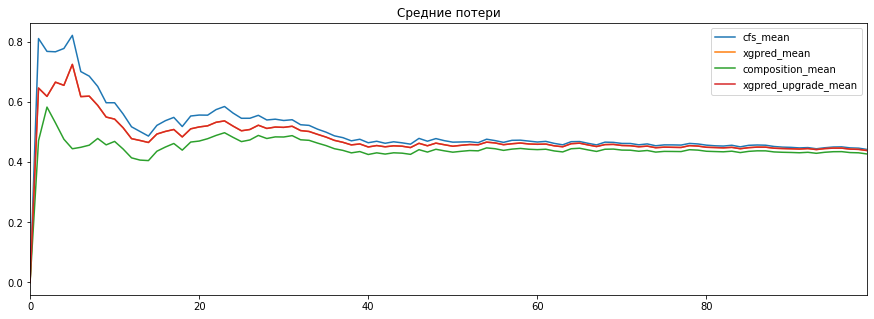

In [14]:
agg[['cfs_mean', 'xgpred_mean', 'composition_mean', 'xgpred_upgrade_mean']].head(100).plot(figsize=(15, 5), title='Средние потери')

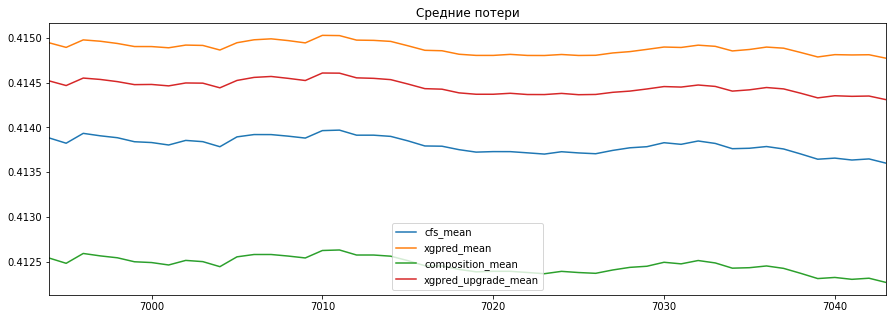

In [15]:
agg[['cfs_mean', 'xgpred_mean', 'composition_mean', 'xgpred_upgrade_mean']].tail(50).plot(figsize=(15, 5), title='Средние потери')

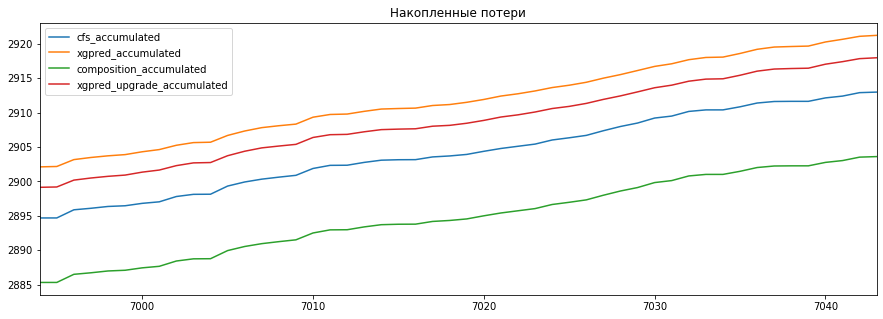

In [16]:
agg[['cfs_accumulated', 'xgpred_accumulated', 'composition_accumulated', 'xgpred_upgrade_accumulated']].tail(50).plot(figsize=(15, 5), title='Накопленные потери')

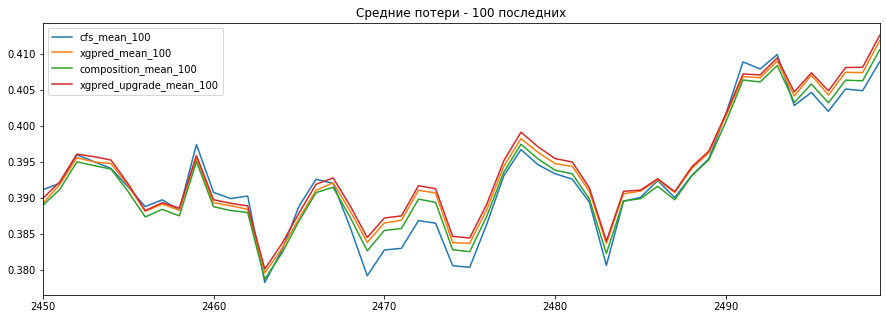

In [31]:
agg[['cfs_mean_100', 'xgpred_mean_100', 'composition_mean_100', 'xgpred_upgrade_mean_100']].head(2500).tail(50).plot(figsize=(15, 5), title='Средние потери - 100 последних')

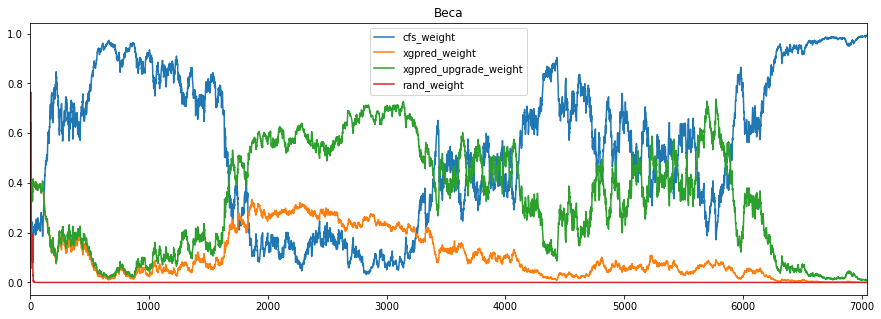

In [18]:
agg[['cfs_weight', 'xgpred_weight', 'xgpred_upgrade_weight', 'rand_weight']].plot(figsize=(15, 5), title='Веса')

In [19]:
test_df = pd.DataFrame()
test_df['res'] = res
test_df['composition_k1'] = agg['composition_k1']
for i in df.columns:
    test_df[i + '_k1'] = np.zeros(df.shape[0])
    for j in range(df.shape[0]):
        test_df[i + '_k1'][j] = df[i][j][0]

# Никто не угадал:

In [20]:
test_df[abs(test_df['composition_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_upgrade_k1'] - test_df['res']) > 0.5][abs(test_df['cfs_k1'] - test_df['res']) > 0.5]

,res,composition_k1,rand_k1,cfs_k1,xgpred_k1,xgpred_upgrade_k1
2,0,0.590660,0.660251,0.602410,0.543715,0.543715
15,0,0.662125,0.552128,0.714286,0.665787,0.665787
16,0,0.573856,0.563029,0.621118,0.562575,0.562575
17,0,0.571567,0.637940,0.602410,0.553281,0.553281
19,0,0.693741,0.534011,0.769231,0.705514,0.705514
...,...,...,...,...,...,...
7027,0,0.580944,0.003442,0.581395,0.546923,0.539397
7028,0,0.554945,0.977066,0.555556,0.509425,0.504702
7030,0,0.601742,0.387852,0.602410,0.547229,0.549139
7032,0,0.580834,0.031494,0.581395,0.545441,0.536768


# Угадала только композиция:

In [21]:
test_df[abs(test_df['composition_k1'] - test_df['res']) < 0.5][abs(test_df['xgpred_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_upgrade_k1'] - test_df['res']) > 0.5][abs(test_df['cfs_k1'] - test_df['res']) > 0.5]

,res,composition_k1,rand_k1,cfs_k1,xgpred_k1,xgpred_upgrade_k1
1,0,0.485660,0.293439,0.636943,0.568597,0.568597
3,1,0.536781,0.741162,0.381679,0.383196,0.383196
4,0,0.388027,0.252767,0.636943,0.558608,0.558608
5,1,0.592307,0.701512,0.294118,0.291482,0.291482
7,1,0.500525,0.532529,0.454545,0.439206,0.439206


# Угадал только xgboost:

In [22]:
test_df[abs(test_df['composition_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_k1'] - test_df['res']) < 0.5][abs(test_df['xgpred_upgrade_k1'] - test_df['res']) > 0.5][abs(test_df['cfs_k1'] - test_df['res']) > 0.5]

,res,composition_k1,rand_k1,cfs_k1,xgpred_k1,xgpred_upgrade_k1
918,0,0.540643,0.170197,0.546448,0.496705,0.502774
1227,0,0.540737,0.828024,0.546448,0.495456,0.500370
1729,0,0.518327,0.705600,0.546448,0.498504,0.503821
2312,0,0.505741,0.146316,0.546448,0.498704,0.502127
2390,0,0.508482,0.156384,0.546448,0.498977,0.501949
2970,0,0.505912,0.381231,0.546448,0.494941,0.504486
3965,0,0.522966,0.763270,0.546448,0.493210,0.501093
4355,0,0.538625,0.001275,0.546448,0.498674,0.501020
4483,0,0.519233,0.622615,0.526316,0.498890,0.503270
4545,0,0.516894,0.596364,0.526316,0.483222,0.501750


# Угадал только xgboost_upgrade

In [23]:
test_df[abs(test_df['composition_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_upgrade_k1'] - test_df['res']) < 0.5][abs(test_df['cfs_k1'] - test_df['res']) > 0.5]

,res,composition_k1,rand_k1,cfs_k1,xgpred_k1,xgpred_upgrade_k1
215,0,0.536170,0.672687,0.546448,0.502587,0.498932
987,0,0.542576,0.348562,0.546448,0.501134,0.499373
1846,0,0.508114,0.183420,0.546448,0.500727,0.497585
2222,0,0.506262,0.930357,0.546448,0.500796,0.499393
3571,0,0.517351,0.334731,0.546448,0.503711,0.499671
3678,0,0.527066,0.618523,0.555556,0.506389,0.497618
3741,0,0.519797,0.587439,0.555556,0.506894,0.499404
4241,0,0.516619,0.795271,0.526316,0.502036,0.496860
4858,0,0.531632,0.821190,0.546448,0.503065,0.497089
5434,0,0.515741,0.737537,0.546448,0.502863,0.493868


# Угадали только букмекеры:

In [24]:
test_df[abs(test_df['composition_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_k1'] - test_df['res']) > 0.5][abs(test_df['xgpred_upgrade_k1'] - test_df['res']) > 0.5][abs(test_df['cfs_k1'] - test_df['res']) < 0.5]

,res,composition_k1,rand_k1,cfs_k1,xgpred_k1,xgpred_upgrade_k1
1682,1,0.499712,0.514435,0.526316,0.484812,0.485677
1826,1,0.496695,0.129760,0.526316,0.473117,0.484815
1900,1,0.496616,0.775310,0.526316,0.488727,0.490391
1934,1,0.491127,0.079274,0.526316,0.481640,0.489774
2104,1,0.493193,0.106622,0.526316,0.491847,0.488220
2160,1,0.495098,0.740648,0.526316,0.486477,0.488000
2190,1,0.488712,0.397480,0.526316,0.482264,0.482399
2472,1,0.484446,0.322233,0.526316,0.478738,0.473895
2497,1,0.492506,0.677209,0.526316,0.488031,0.481098
2499,1,0.496386,0.281087,0.526316,0.490758,0.484786
